In [2]:
import numpy as np
import h5py
import cv2
import tempfile
import imageio
import pandas as pd
import scipy.signal as ss

import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image

In [3]:
import plotly.io as pio
pio.renderers.default = 'browser'

# H5J to numpy Array

### H5J prefered to .png because it removes background image

In [6]:
#extract channel

def extract_channel(raw_data, nframes, height, width):
    with tempfile.NamedTemporaryFile(delete=True, suffix='.mp4') as temp_file:
        temp_file.write(raw_data)
        temp_file_name = temp_file.name

        # Create a reader object for the temporary file
        reader = imageio.get_reader(temp_file_name, 'ffmpeg')
        frames = np.empty((nframes, height, width), np.uint8)
        for i in range(nframes):
            frames[i] = reader.get_data(i)[:,:,0]
    return frames


# flexible: for 1 or 3 channels (called RGB even if 1 channel)

def read_h5j(filename):
    with h5py.File(filename, 'r') as h5file:
        # Read global attributes
        attributes = {tmp: h5file.attrs[tmp] for tmp in h5file.attrs}
        
        # Read channel attributes
        channel_attributes = {tmp: h5file['Channels'].attrs[tmp] for tmp in h5file['Channels'].attrs}
        nframes = channel_attributes['frames'][0]
        height = channel_attributes['height'][0] + channel_attributes['pad_bottom'][0]
        width = channel_attributes['width'][0] + channel_attributes['pad_right'][0]
        
        # Detect available channels
        channel_keys = list(h5file['Channels'].keys())
        num_channels = len(channel_keys) - 1  # Assuming last channel is 'reference'
        
        # Extract image channels
        channels = []
        for i in range(num_channels):
            channel_data = extract_channel(h5file["Channels"][f'Channel_{i}'][()].tobytes(), nframes, height, width)
            channels.append(channel_data)
        
        # Concatenate RGB or return single channel
        if num_channels == 3:
            RGB = np.concatenate([channel[:, :, :, None] for channel in channels], axis=3)  # Stack R, G, B
        elif num_channels == 1:
            RGB = channels[0]  # Single channel
        
        # Extract reference channel
        reference = extract_channel(h5file["Channels"][f'Channel_{num_channels}'][()].tobytes(), nframes, height, width)
    
    return RGB, reference, attributes


# Functions for Processing & Visualizing

In [108]:
# using oriignal approach, but 2D gaussian:

def process_channel(im, scale=2, min_size=500): # min_size for connected components
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(im, (5, 5), 0)

    # Set scale and window size for kernel
    windowsize = 8 * 2 * scale + 1
    xx, yy = np.meshgrid(np.arange(-(windowsize//2), windowsize//2 + 1),
                         np.arange(-(windowsize//2), windowsize//2 + 1))

    # Define 2D Gaussian kernel
    sigma = 2.9 * scale         # sigma is st.dev
    gaussian = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    gaussian /= gaussian.sum()

    kernel = gaussian  # 2D Gaussian kernel

    kernel1 = Image.fromarray(kernel)  # convert kernel array to image

    #calc 8 angles
    angles = np.arange(0, 180, 180/8)

    # define outputs
    outputs = np.zeros([len(angles)] + list(im.shape))
    for i, angle in enumerate(angles):
        ker = kernel1.rotate(angle, resample=Image.BICUBIC)  # rotate by angle
        output = ss.convolve2d(blurred, ker, mode='full', boundary='symm')
        outputs[i] = output[windowsize//2:-(windowsize//2), windowsize//2:-(windowsize//2)]

    binary_mask = (blurred > (outputs.min(axis=0) + 1)).astype(np.uint8)  # binary threshold # can adjust constant value # changed from 15 to 2

    # define connected components to rid noise
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    filtered_mask = np.zeros_like(binary_mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            filtered_mask[labels == i] = 1

    return filtered_mask, binary_mask, blurred

# Function to visualize results
def visualize_results(original, filtered_mask, binary_mask):
    fig, axs = plt.subplots(3, 1, figsize=(18, 18))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original Channel')
    axs[1].imshow(binary_mask, cmap='gray') # after applying binary threshold
    axs[1].set_title('Binary Mask')
    axs[2].imshow(filtered_mask, cmap='gray') # including connected components analysis
    axs[2].set_title('Filtered Mask')
    plt.tight_layout()
    plt.show()

# Image 1: Split Gal4

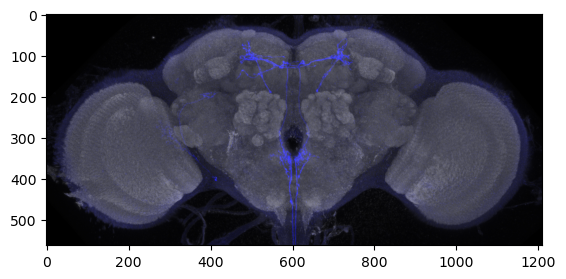

In [85]:
# Show PNG
path = ('/Users/sarahbinder/Downloads/SS00837-20230210_46_A3-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.png')
full_im = cv2.imread(path)
plt.imshow(full_im)


In [94]:
RGB, reference, attributes = read_h5j('/Users/sarahbinder/Downloads/SS00837-20230210_46_A3-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.h5j')
B = RGB # rename to reflect that it is just the blue channel

In [8]:
reference.shape

(182, 568, 1216)

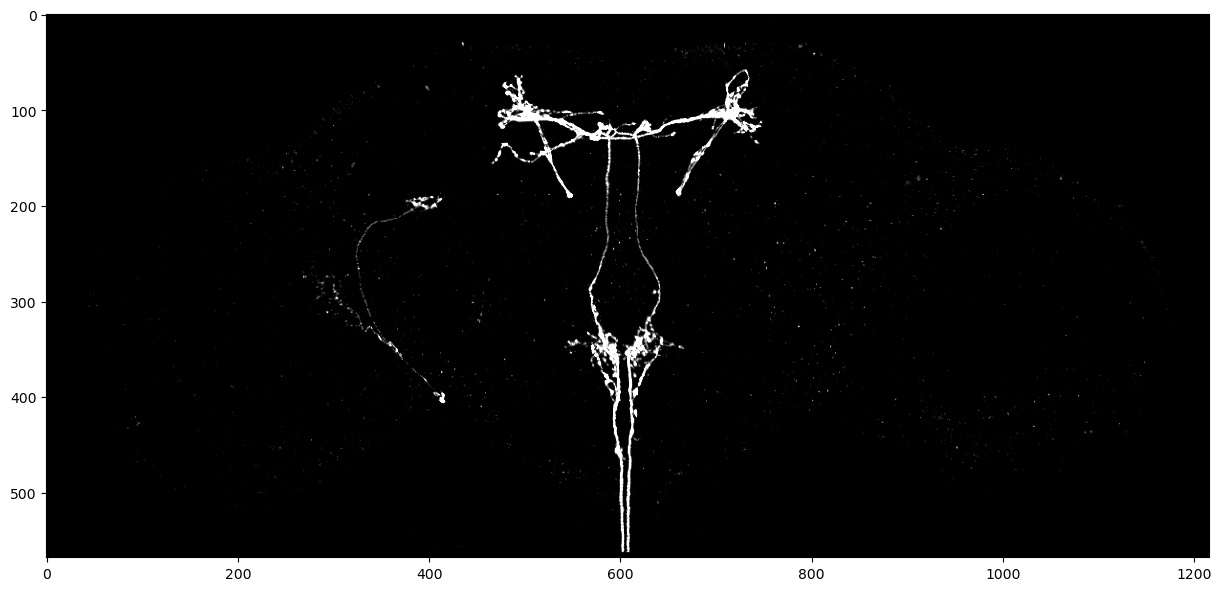

In [95]:
# visualize
# max intensity across all frames for the image channel (this image has only one channel) #blue 

# B is 4D array with nframes, h, w, channels, in this case channels is 1
# axis=0 returns max nframes

fig = plt.figure(figsize = (15,15))
plt.imshow(B.max(axis=0), cmap = 'gray', vmax=50)
plt.show()

im = B.max(axis=0)

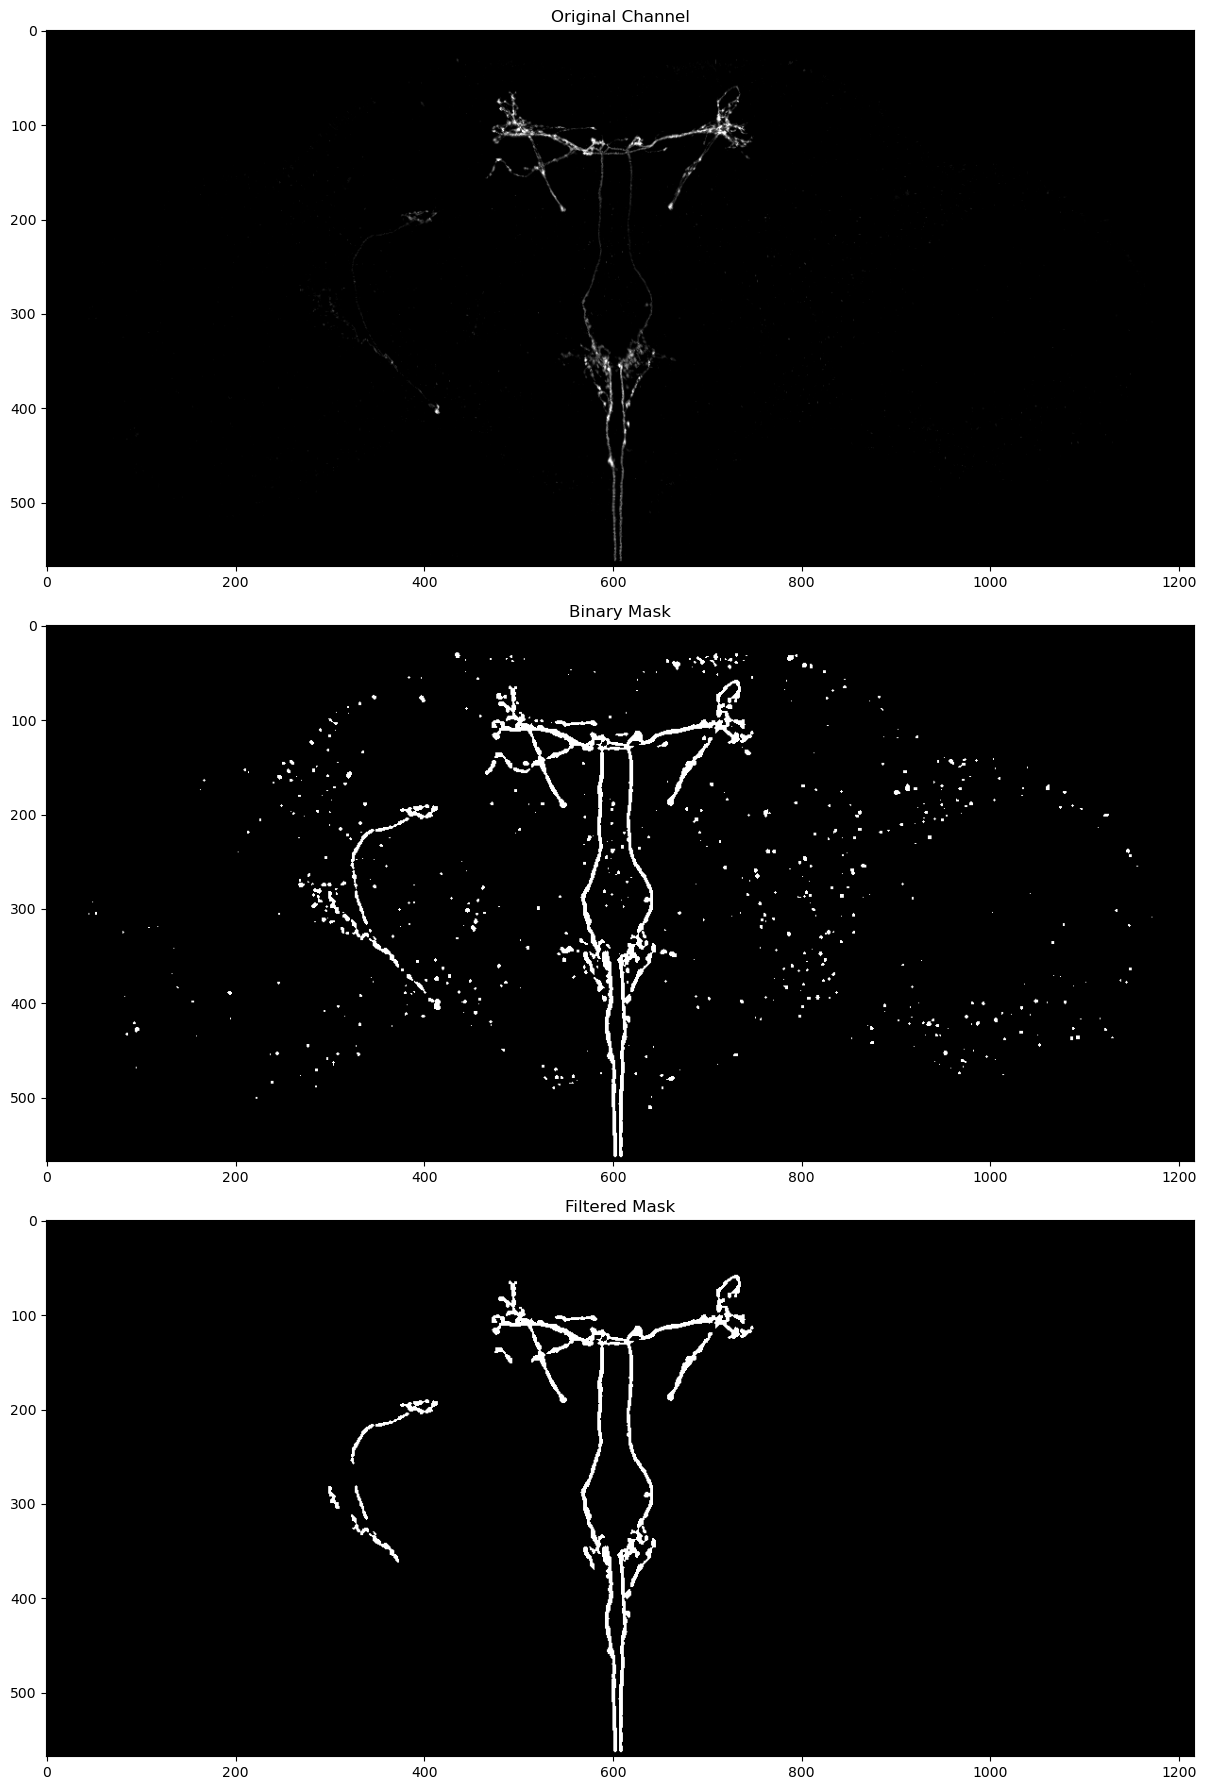

In [96]:
# Process blue channel saved as im 

filtered_mask, binary_mask, blurred = process_channel(im)
visualize_results(im, filtered_mask, binary_mask)


# Image 2: Gal4

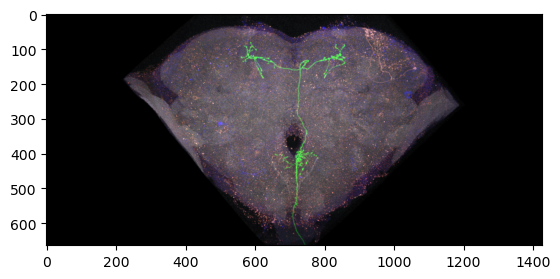

In [103]:
# load as h5j
path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/R27C09-20181221_62_F1-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j'
RGB, reference, attributes = read_h5j(path)

png_path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/R27C09-20181221_62_F1-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.png'

# Show PNG
full_im = cv2.imread(png_path)
plt.imshow(full_im)

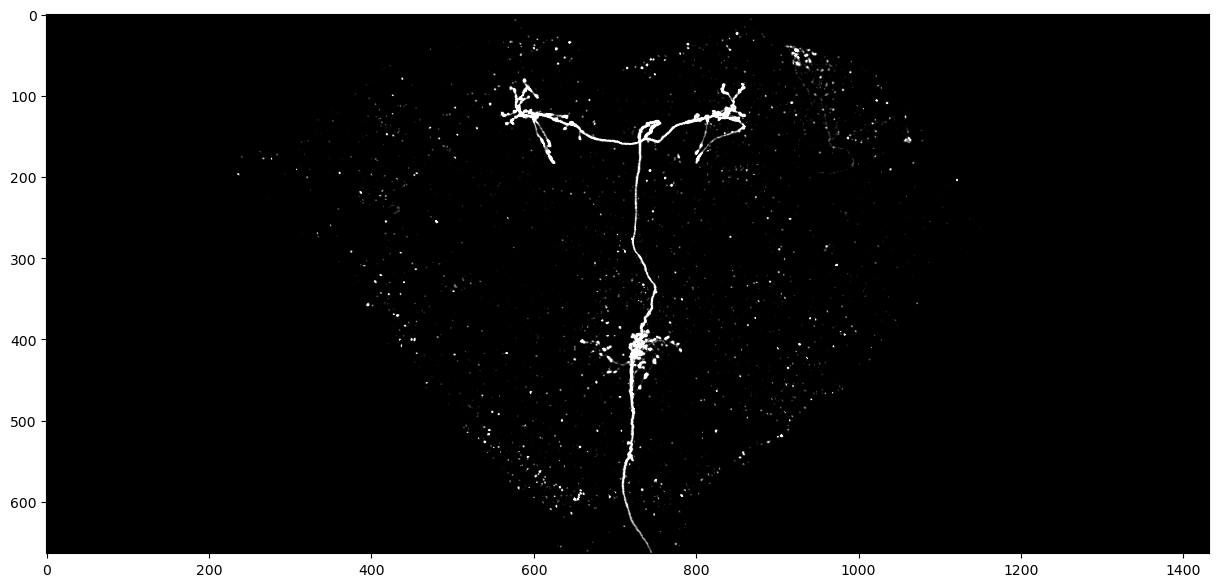

In [104]:
# visualize 1 channel

RGB.shape # 3 channels
G = RGB[:,:,:,1]

fig = plt.figure(figsize = (15,15))
plt.imshow(G.max(axis=0), cmap = 'gray', vmax=50)
plt.show()

im = G.max(axis=0)

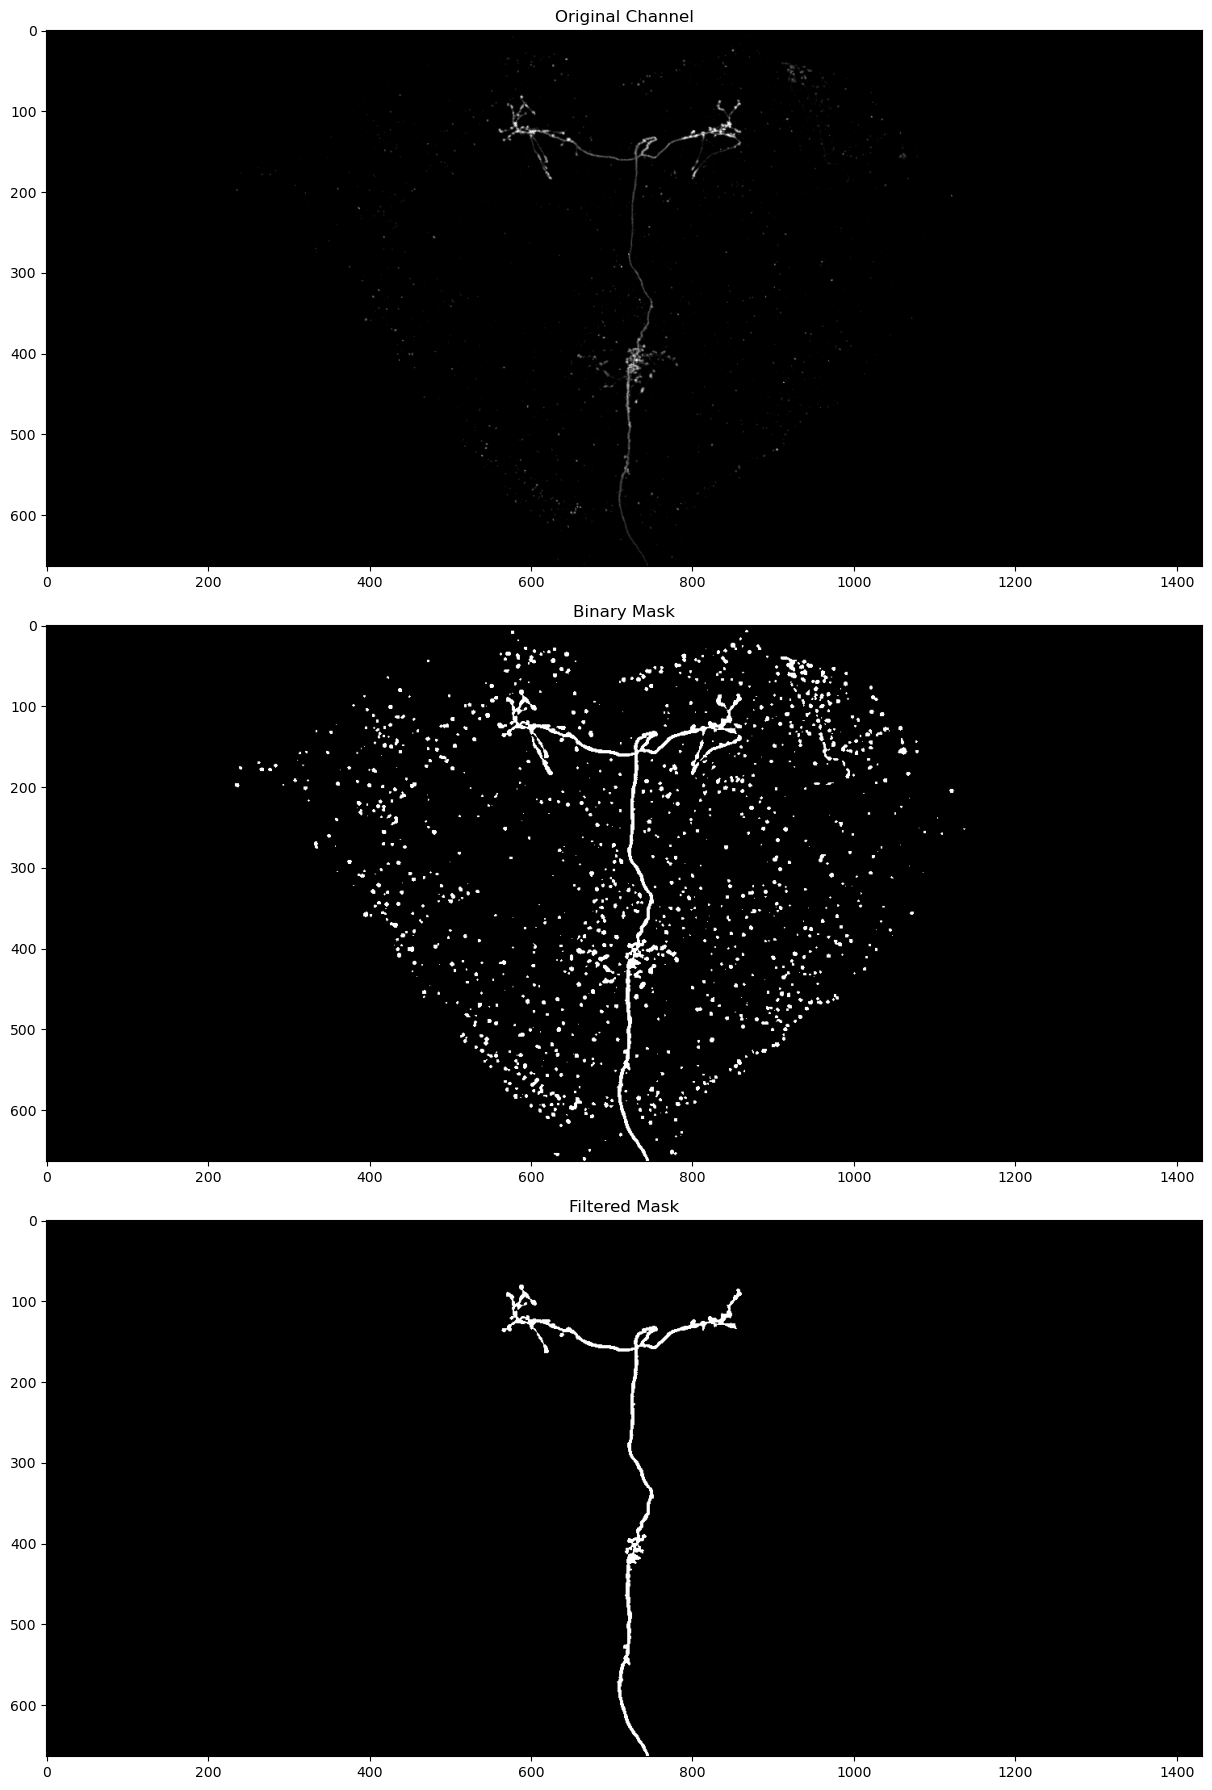

In [109]:
# Process green channel saved as im 

filtered_mask, binary_mask, blurred = process_channel(im)
visualize_results(im, filtered_mask, binary_mask)


# Image 3: Gen1 MCFO 
### not clear which neuron

In [67]:
path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/11.25/R28E11-20190702_65_G3-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j'
RGB, reference, attributes = read_h5j(path)


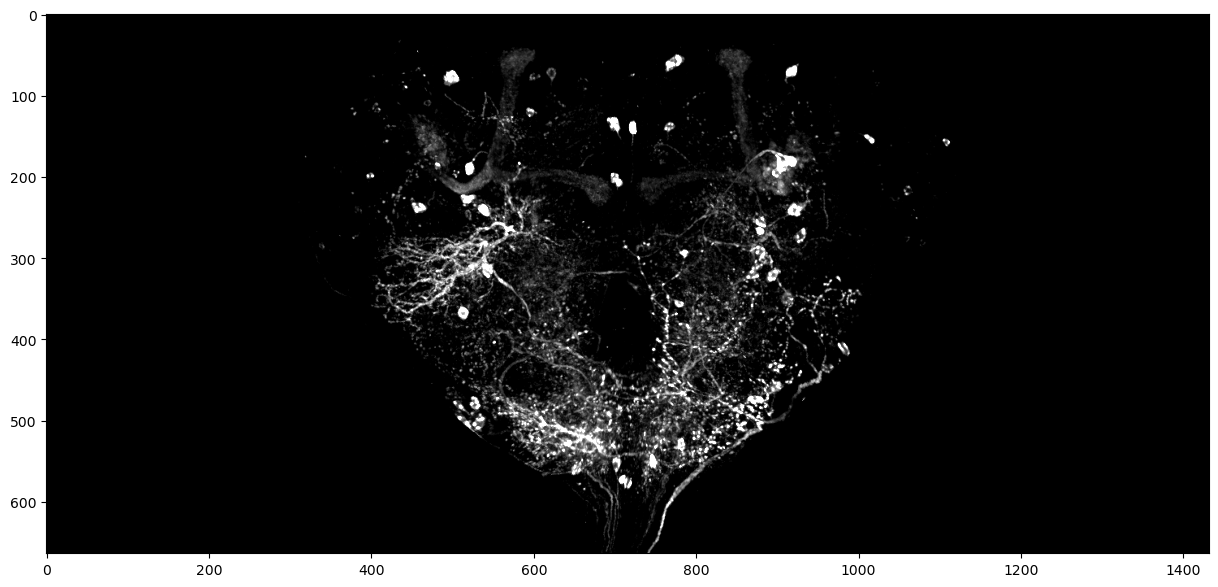

In [72]:
RGB.shape

# reassign to B, 1 channel
B = RGB[:,:,:,1]

# show
fig = plt.figure(figsize = (15,15))
plt.imshow(B.max(axis=0), cmap = 'gray', vmax=50)
plt.show()

im = B.max(axis=0)


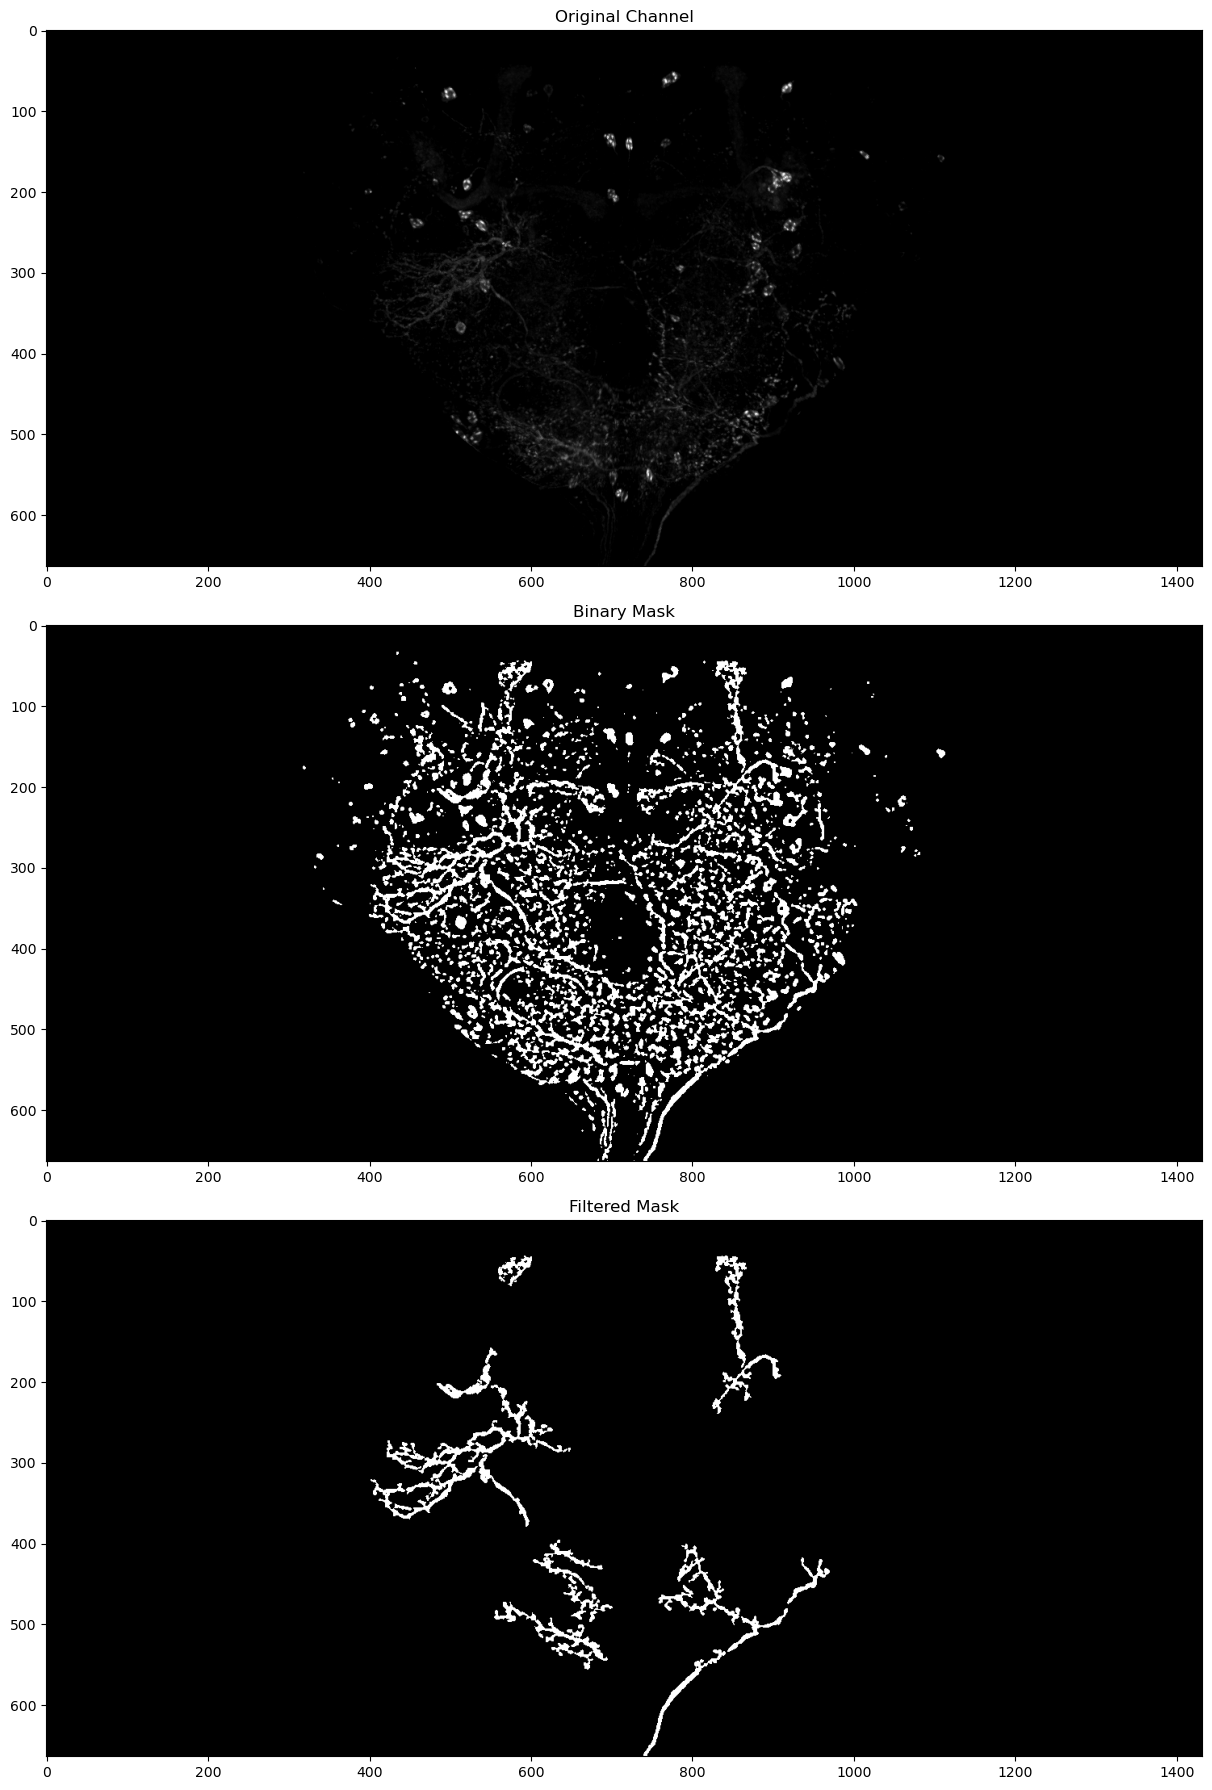

In [73]:
filtered_mask, binary_mask, blurred = process_channel(im)
visualize_results(im, filtered_mask, binary_mask)

# Image 4: Split GAL4 Omnibus Rescreen

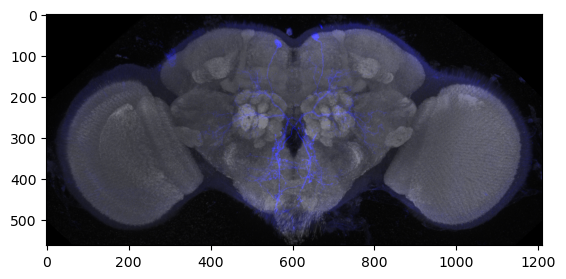

In [74]:
path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/11.25/SS01580-20191127_42_E5-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.h5j'
png_path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/11.25/SS01580-20191127_42_E5-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.png'

# load as h5j
RGB, reference, attributes = read_h5j(path)

# Show PNG
full_im = cv2.imread(png_path)
plt.imshow(full_im)

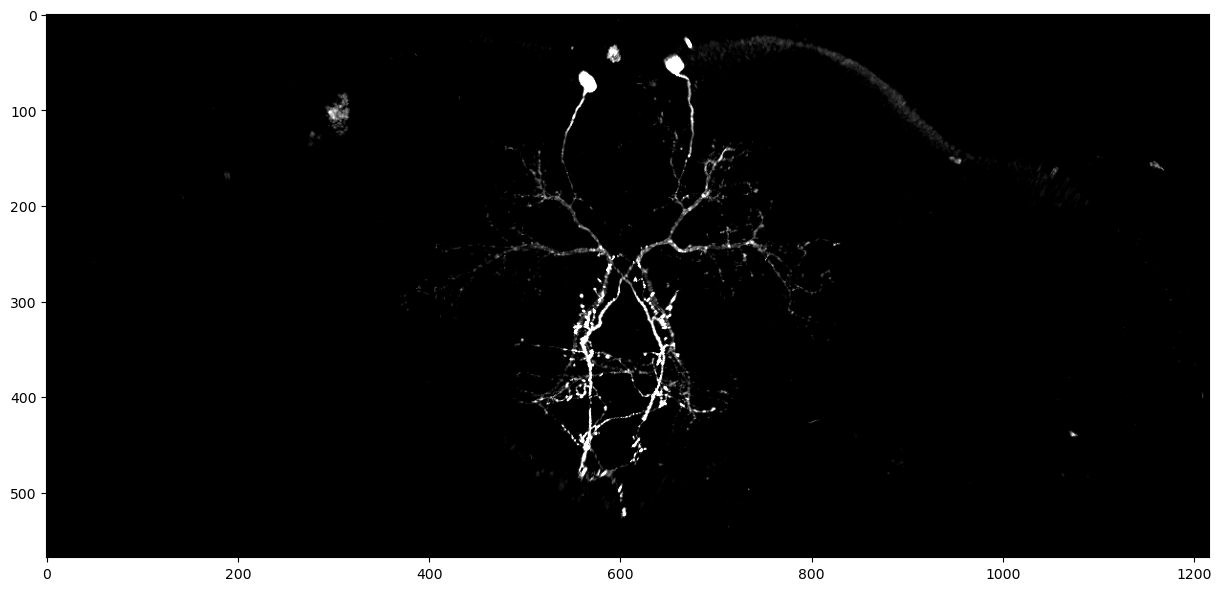

In [76]:
# this one performs better with lower minsize

B = RGB

# show
fig = plt.figure(figsize = (15,15))
plt.imshow(B.max(axis=0), cmap = 'gray', vmax=50)
plt.show()

im = B.max(axis=0) 

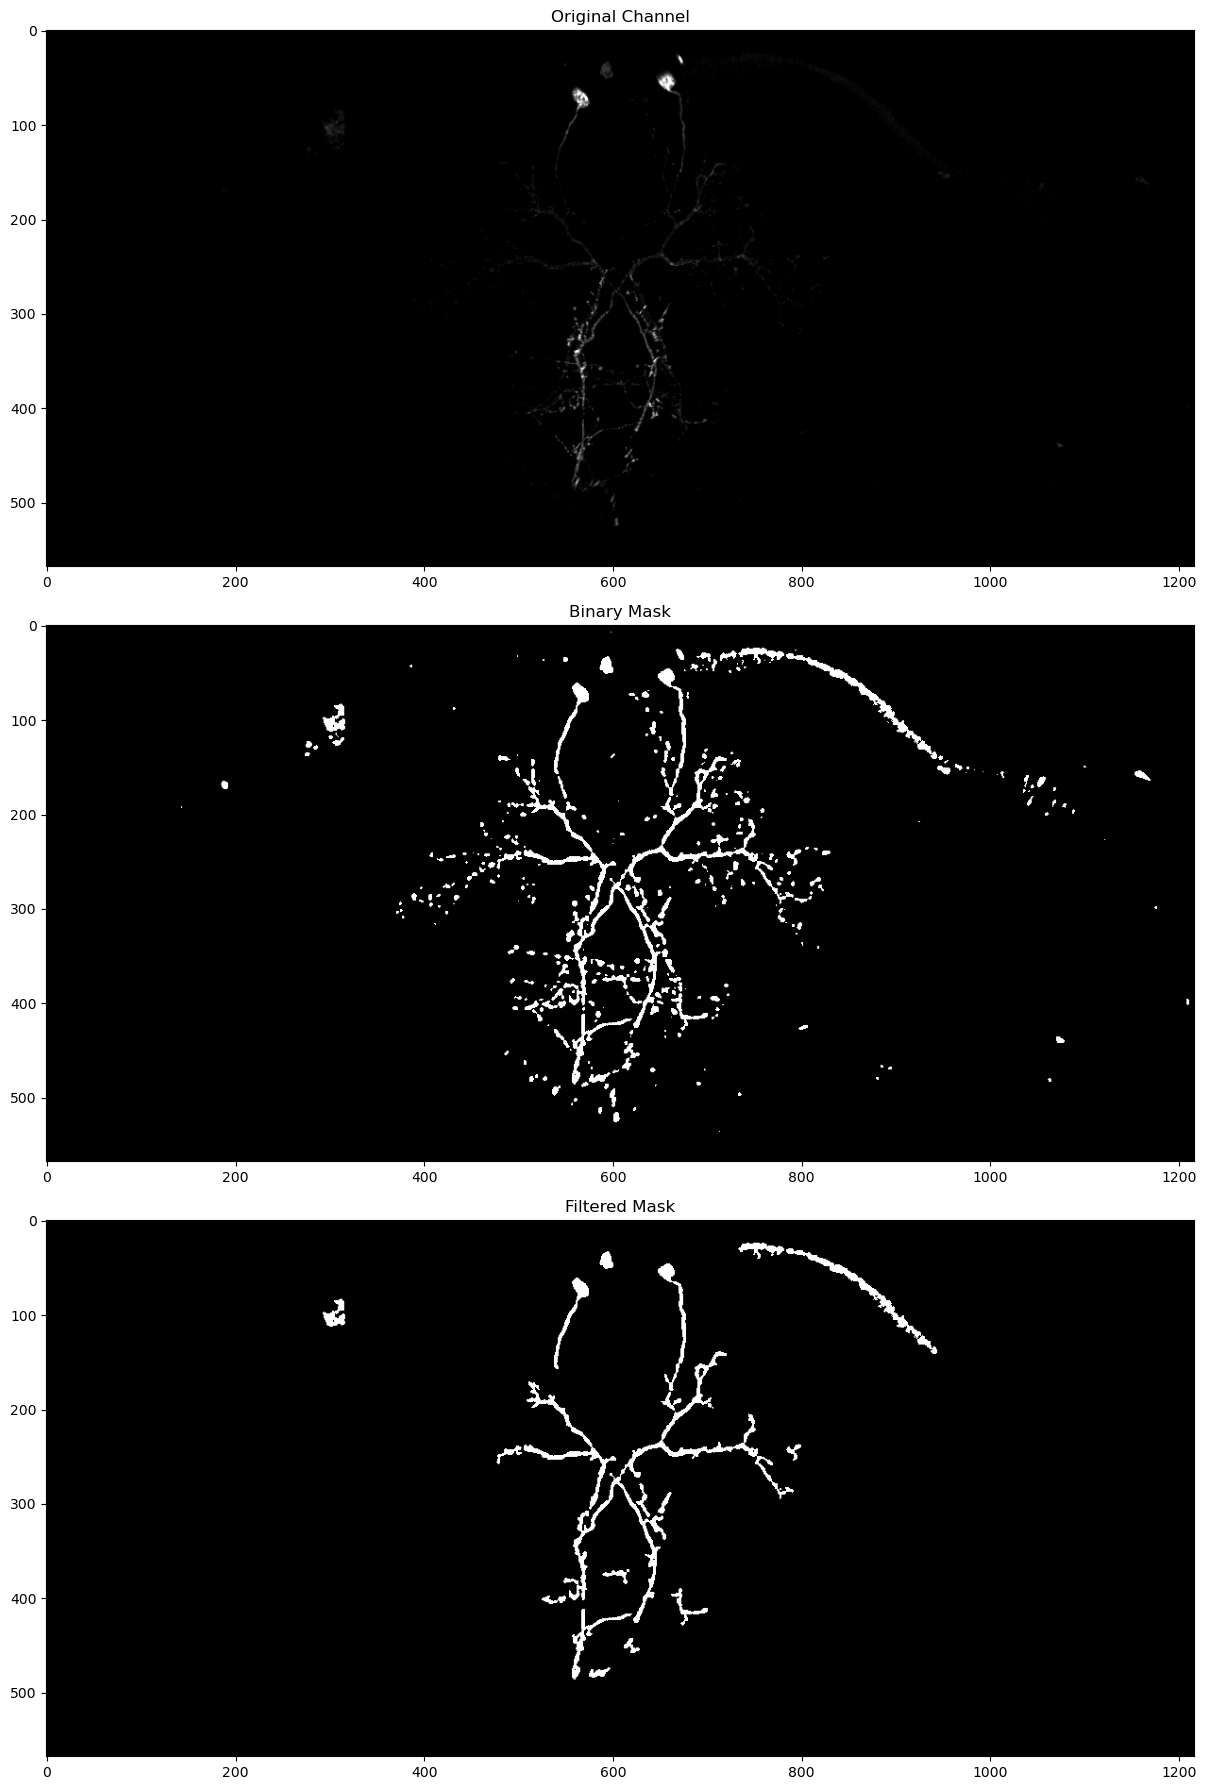

In [81]:
filtered_mask, binary_mask, blurred = process_channel(im)
visualize_results(im, filtered_mask, binary_mask)

# Image 5: MB

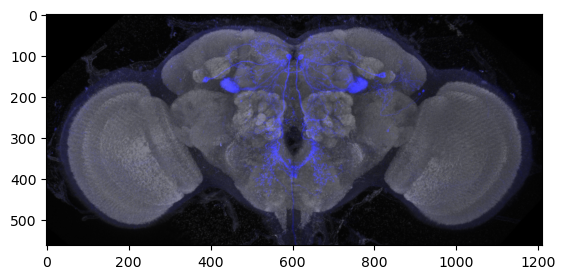

In [60]:
path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/11.25/MB320C-20230407_43_J1-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.h5j'
png_path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/11.25/MB320C-20230407_43_J1-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.png'

# load as h5j
RGB, reference, attributes = read_h5j(path)

# Show PNG
full_im = cv2.imread(png_path)
plt.imshow(full_im)

In [61]:
RGB.shape

(182, 568, 1216)

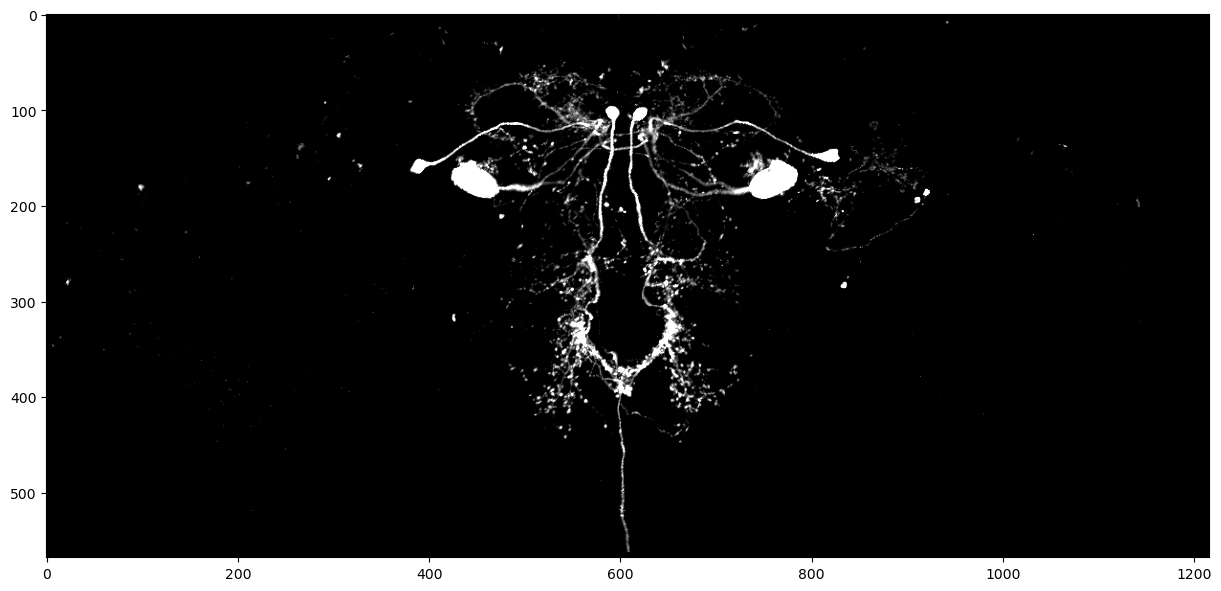

In [62]:
# reassign to B, 1 channel
B = RGB

# show
fig = plt.figure(figsize = (15,15))
plt.imshow(B.max(axis=0), cmap = 'gray', vmax=50)
plt.show()

im = B.max(axis=0)

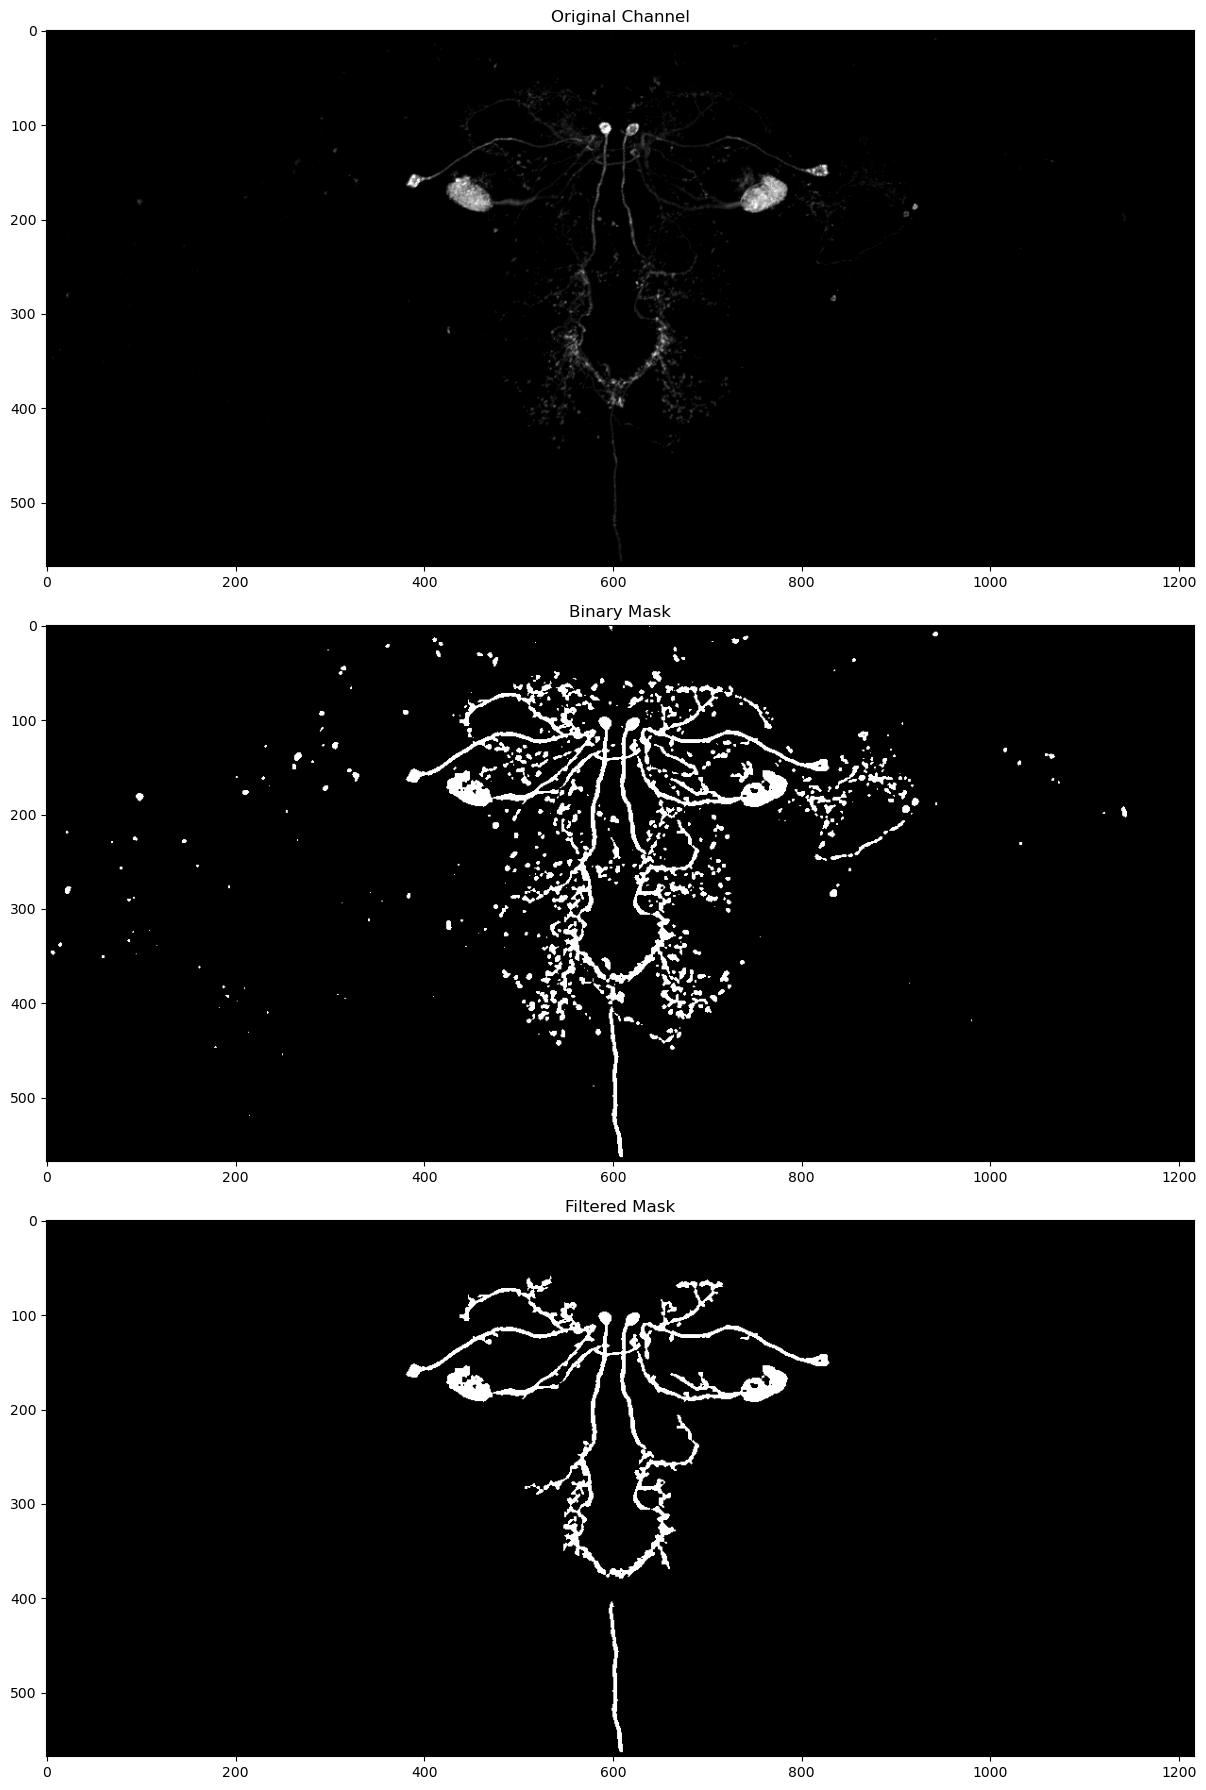

In [63]:
filtered_mask, binary_mask, blurred = process_channel(im)
visualize_results(im, filtered_mask, binary_mask)

# Compare to 1D Gaussian

In [100]:
def one_d_process_channel(im, scale=2, min_size=500):
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(im, (5, 5), 0)

    # Set scale and window size for kernel
    windowsize = 8 * 2 * scale + 1
    xx = np.arange(-(windowsize//2), windowsize//2 + 1)

    # Define gaussian kernel
    sigma = 2.9 * scale
    gaussian = np.exp(-xx**2 / (2*sigma**2))  # 1D gaussian function # try 2D gaussian, for more width to capture more than a thin line # sigma x sigma y
    gaussian /= gaussian.sum()

    kernel = np.zeros((windowsize, windowsize)) 
    kernel[windowsize//2, :] = gaussian  # apply 1D gaussian to center row
    #

    kernel1 = Image.fromarray(kernel)  # convert kernel array to image

    angles = np.arange(0, 180, 180/8)

    outputs = np.zeros([len(angles)] + list(im.shape))
    for i, angle in enumerate(angles):
        ker = kernel1.rotate(angle, resample=Image.BICUBIC)  # rotate by angle
        output = ss.convolve2d(blurred, ker, mode='full', boundary='symm')
        outputs[i] = output[windowsize//2:-(windowsize//2), windowsize//2:-(windowsize//2)]

    binary_mask = (blurred > (outputs.min(axis=0) + 2)).astype(np.uint8)  # binary threshold

    # Label connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    filtered_mask = np.zeros_like(binary_mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            filtered_mask[labels == i] = 1

    return filtered_mask, binary_mask, blurred

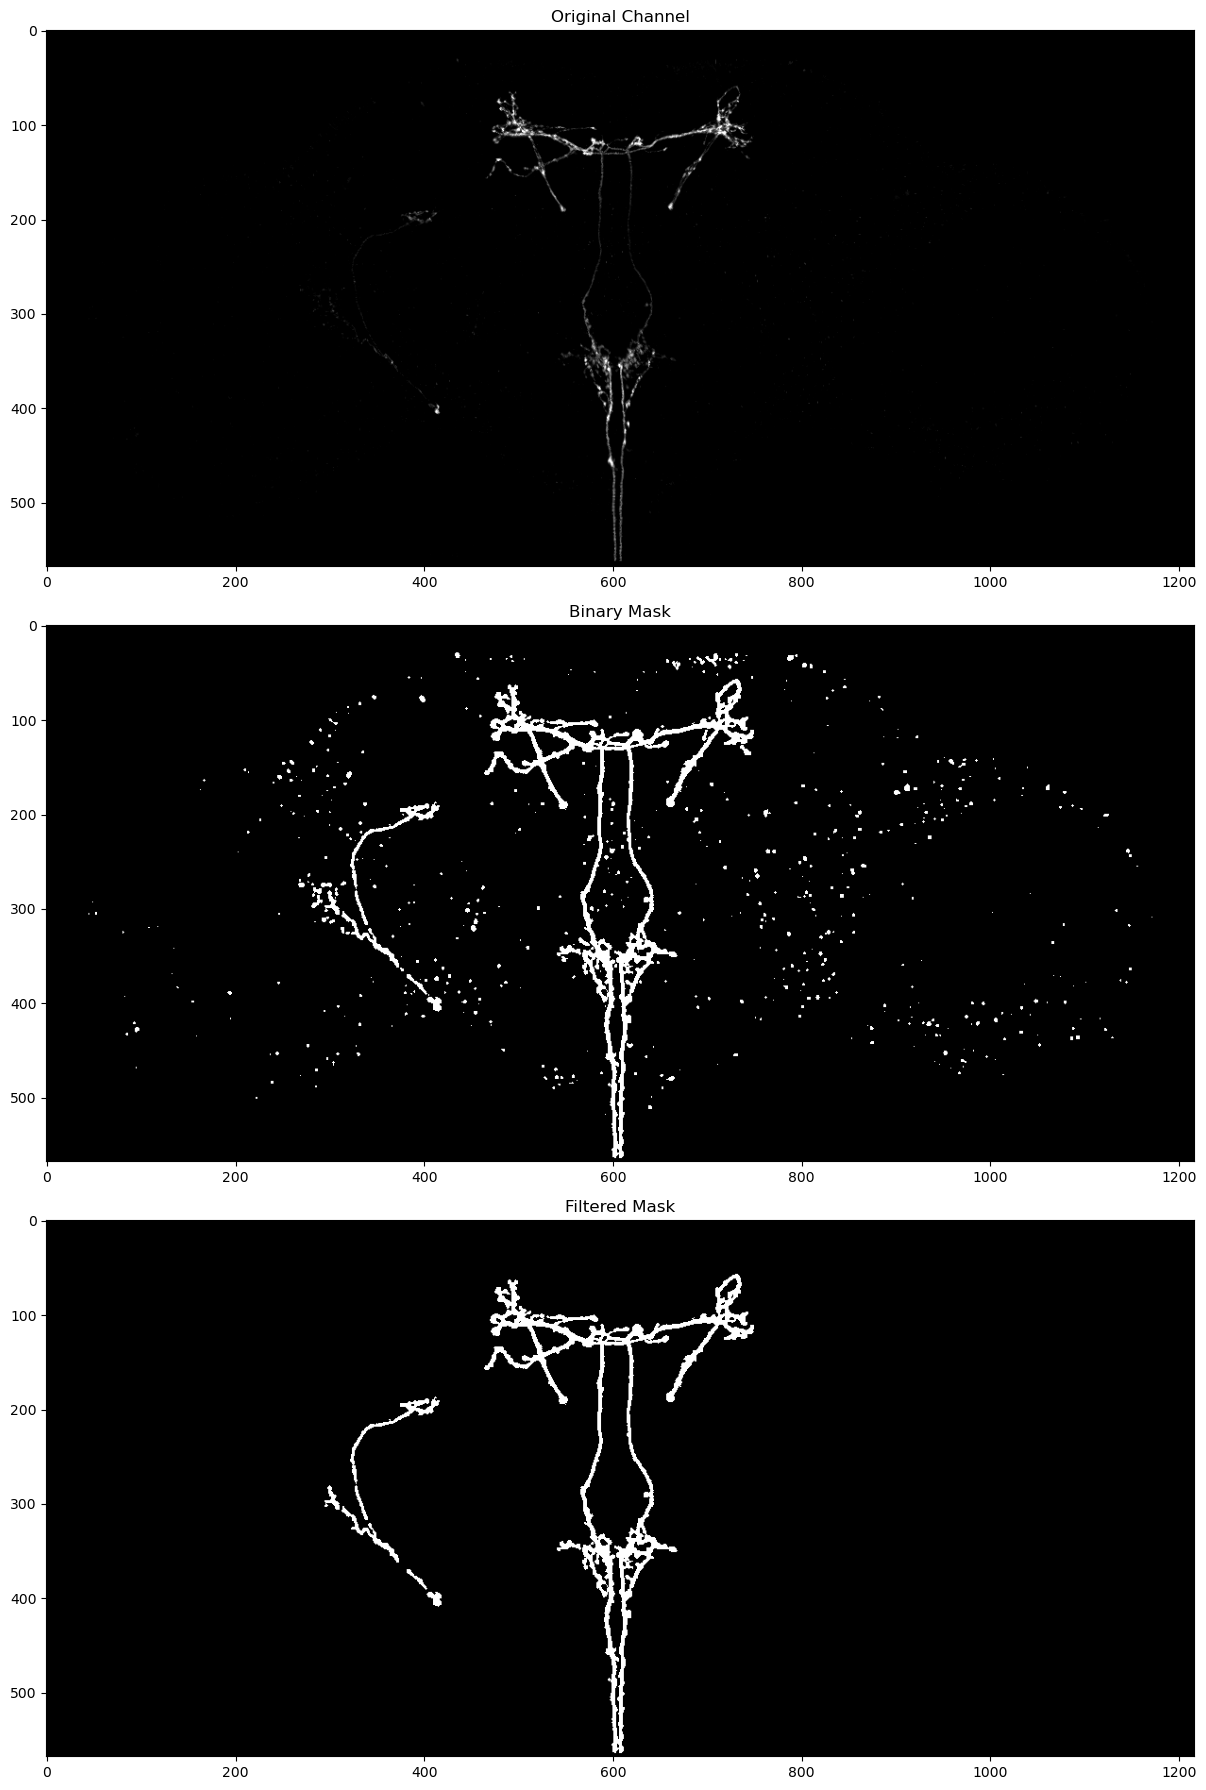

In [93]:
# try on first image

RGB, reference, attributes = read_h5j('/Users/sarahbinder/Downloads/SS00837-20230210_46_A3-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.h5j')
B = RGB # rename to reflect that it is just the blue channel
im = B.max(axis=0)

filtered_mask, binary_mask, blurred = one_d_process_channel(im)
visualize_results(im, filtered_mask, binary_mask)

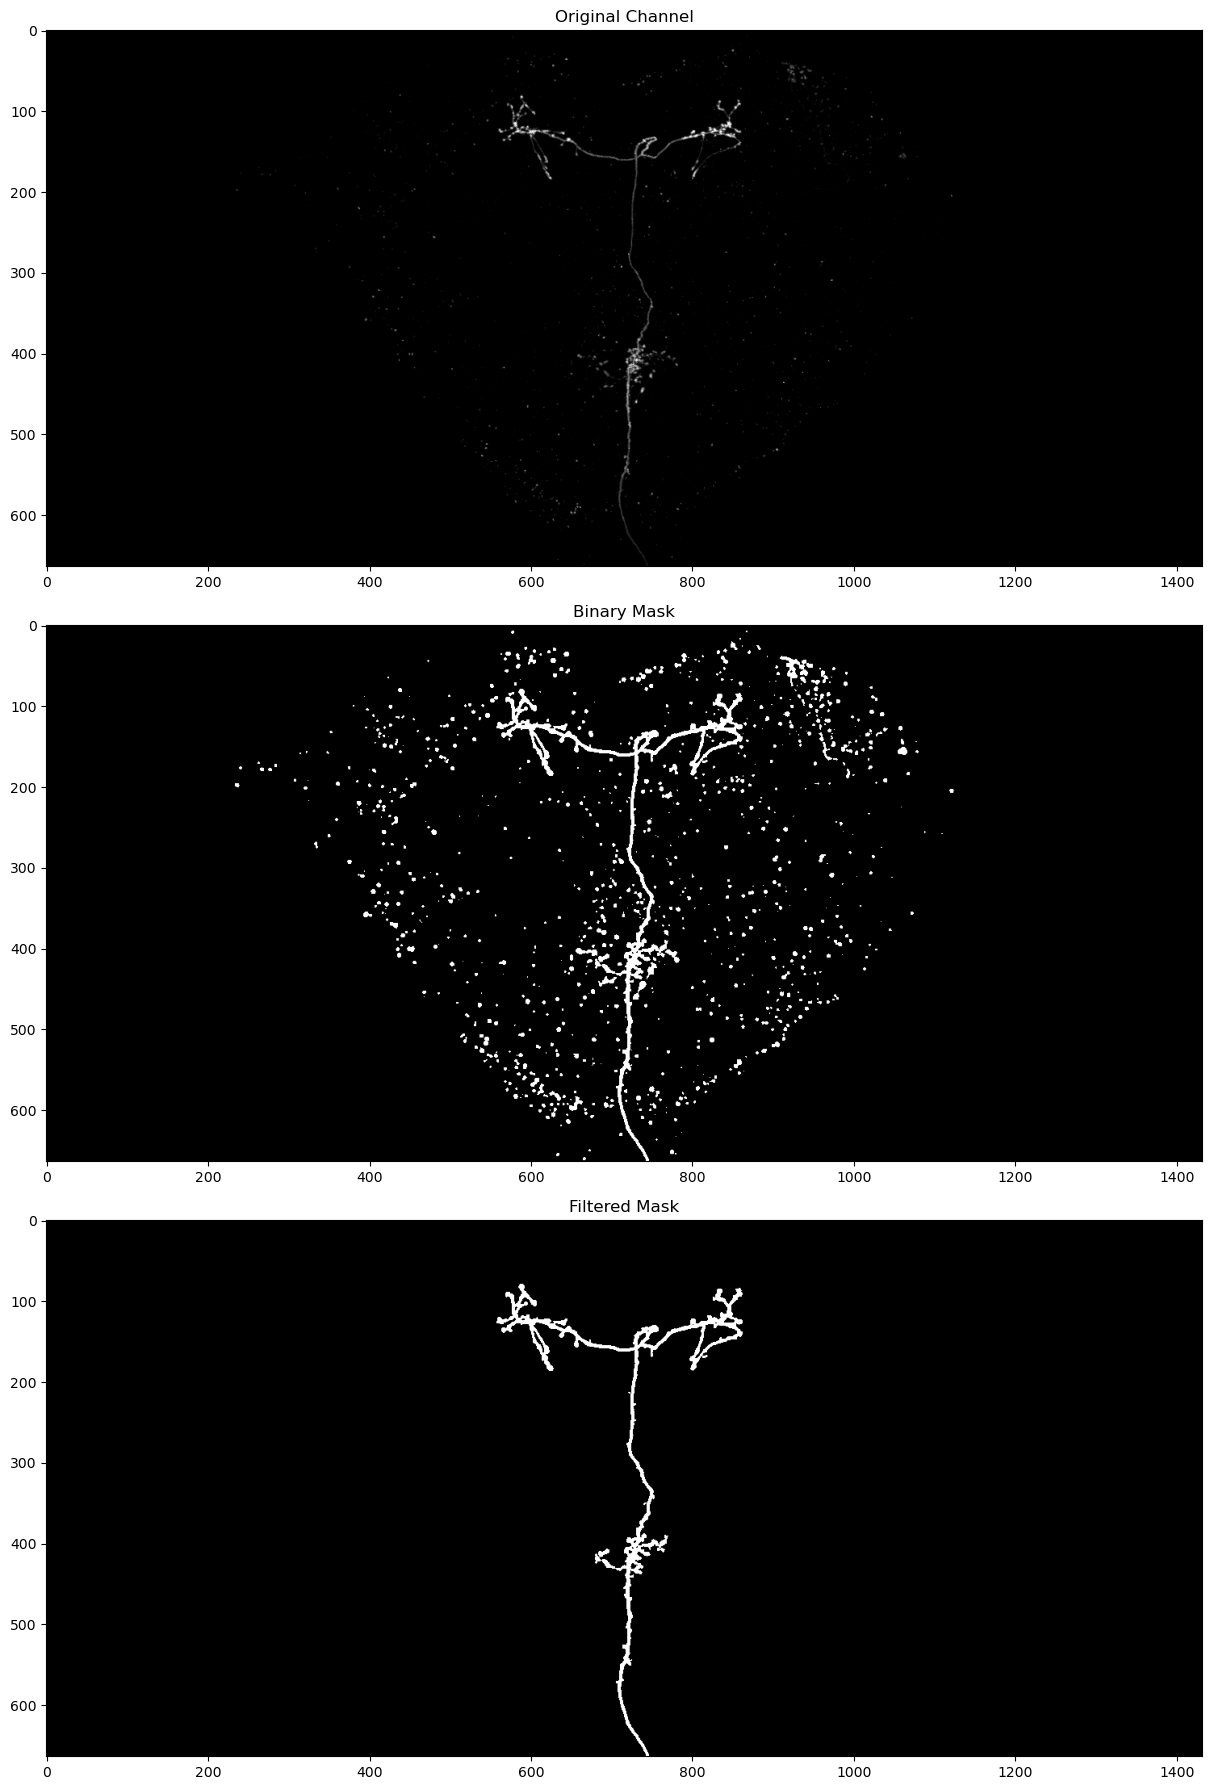

In [101]:
# second image (original)

path = '/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/R27C09-20181221_62_F1-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j'
RGB, reference, attributes = read_h5j(path)
G = RGB[:,:,:,1]
im = G.max(axis=0)

filtered_mask, binary_mask, blurred = one_d_process_channel(im)
visualize_results(im, filtered_mask, binary_mask)